In [5]:
import pyvinecopulib as pvcl

import numpy as np
import pandas as pd

import datetime
import pandas_datareader as pdr

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2017,1,1) # datetime.date.today()
symbols = ["AAPL", "IBM", "GOOGL", "AMZN"]
panel = pdr.get_data_yahoo(symbols, start, end).transpose(1,0,2)
df = panel.to_frame().xs('Close', axis=0, drop_level=True)
df.head()

Date,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
minor,,,,,,,,,,,,,,,,,,,,,
AAPL,105.349998,102.709999,100.699997,96.449997,96.959999,98.529999,99.959999,97.389999,99.519997,97.129997,...,115.970001,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000
AMZN,636.989990,633.789978,632.650024,607.940002,607.049988,617.739990,617.890015,581.809998,593.000000,570.179993,...,757.770020,766.000000,771.219971,770.599976,766.340027,760.590027,771.400024,772.130005,765.150024,749.869995
GOOGL,759.440002,761.530029,759.330017,741.000000,730.909973,733.070007,745.340027,719.570007,731.390015,710.489990,...,809.840027,812.500000,815.200012,812.200012,809.679993,807.799988,809.929993,804.570007,802.880005,792.450012
IBM,135.949997,135.850006,135.169998,132.860001,131.630005,133.229996,132.899994,131.169998,132.910004,130.029999,...,166.729996,166.679993,167.600006,167.330002,167.059998,166.710007,167.139999,166.190002,166.600006,165.990005


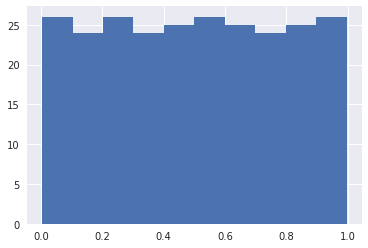

In [92]:
#log returns
returns = np.log(df).diff(axis=1).ix[:,1:]

def empirical_cdf(data):
    return data.dropna().rank(axis=1) / (len(data.columns) + 1) ####remove the +1

#empirical cdf
emp = empirical_cdf(returns)
emp.iloc[0,:].hist(bins=10)

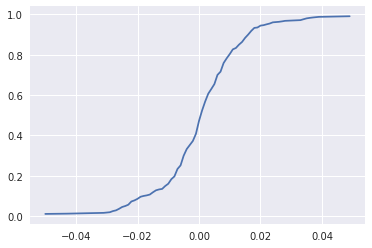

0.000755948241931037
[ 0.00075595  0.00260392]


In [157]:
import scipy.interpolate as interpolate
import scipy.optimize as optimize

#empirical cdf function
cdf = interpolate.interp1d(returns.iloc[0,:], emp.iloc[0,:], fill_value="extrapolate")

x = np.arange(-.05, .05, 0.001)
y = cdf(x)   # use interpolation function returned by `interp1d`
plt.plot(x, y)
plt.show()

#inverse cdf
def inverse_cdf(cdf, y):
    def func(x):
        return cdf(x) - y
    return optimize.bisect(func, -1, 1)

v_inverse_cdf = np.vectorize(inverse_cdf)

print(inverse_cdf(cdf, 0.5))
print(v_inverse_cdf(cdf, [0.5,0.6]))

In [237]:
pvcl.vinecop(emp.values)

In [98]:
fitted = pvcl.vinecop(4)

fit_controls = pvcl.vinecop_fit_controls()
fit_controls.family_set = [
    pvcl.bicop_family.indep,
    pvcl.bicop_family.gaussian,
    pvcl.bicop_family.student,
    pvcl.bicop_family.clayton,
    pvcl.bicop_family.gumbel,
    pvcl.bicop_family.frank,
]
fit_controls.truncation_level = 2

fitted.select_all(emp.values, fit_controls)

In [100]:
print(fitted.matrix)
print(fitted.matrix[2,1])
print(fitted.family(0,2))
print(fitted.parameters(0,2))
print(fitted.rotation(0,2))

[[3 4 1 2]
 [3 1 4 0]
 [1 3 0 0]
 [1 0 0 0]]
3
gumbel
[1.5542758286705793]
180


In [231]:
num_draws = 1000
sim_unif = pd.DataFrame(fitted.simulate(num_draws), index=df.index.values)
sim_unif.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
AAPL,0.843004,0.039939,0.935792,0.296656,0.705253,0.991556,0.323573,0.297617,0.703984,0.761264,...,0.916390,0.195545,0.787997,0.721871,0.762997,0.665160,0.585333,0.075149,0.897629,0.992225
AMZN,0.995030,0.061002,0.687940,0.423706,0.661985,0.996098,0.383089,0.291637,0.542352,0.754518,...,0.297202,0.892042,0.645432,0.704311,0.075205,0.637133,0.307756,0.033282,0.853756,0.951046
GOOGL,0.958815,0.046089,0.658550,0.262330,0.818272,0.969399,0.604155,0.160597,0.240542,0.637286,...,0.845027,0.500475,0.862567,0.894197,0.149606,0.657777,0.553983,0.026227,0.880448,0.838256
IBM,0.978617,0.059667,0.523804,0.163874,0.897495,0.980670,0.542055,0.766666,0.096078,0.760218,...,0.938807,0.173588,0.731619,0.748717,0.724029,0.947138,0.414249,0.600387,0.842812,0.622778


In [164]:
v_inverse_cdf(cdf, sim_unif.iloc[1,:])

array([  5.91993741e-03,  -3.59063482e-03,  -7.57416116e-03,
        -5.71249465e-03,   1.73606823e-02,  -5.71997334e-03,
         5.04789224e-03,   2.19495784e-03,   7.91889431e-03,
         3.62933442e-02,  -2.39618689e-03,   9.41405362e-04,
         3.05542738e-03,  -9.40240369e-03,   1.98524594e-03,
         7.60016231e-03,   7.85023583e-04,  -2.18413498e-02,
         1.07398452e-02,  -4.38589832e-05,   2.15378099e-03,
        -1.60441473e-03,  -5.70315889e-03,  -5.55310788e-03,
         5.03404318e-03,   1.50637238e-02,  -3.60841010e-04,
         1.46210271e-03,  -4.32142747e-03,  -5.85770929e-03,
        -1.37842138e-02,   1.64487206e-02,   6.71929153e-03,
         1.72968870e-02,  -9.59983026e-05,   2.04930000e-03,
        -1.99866165e-02,  -1.25367074e-03,   3.79135446e-02,
         1.51955679e-03,  -3.92569544e-03,   1.20069853e-03,
        -1.16683698e-02,   1.61317524e-02,   1.14838921e-03,
         2.58398805e-03,   1.77405666e-02,   7.68185867e-03,
         4.37182222e-03,

In [166]:
returns.iloc[1,:].values

array([ -5.03630659e-03,  -1.80025000e-03,  -3.98411884e-02,
        -1.46505595e-03,   1.74565005e-02,   2.42831592e-04,
        -6.01665419e-02,   1.90504685e-02,  -3.92423108e-02,
         7.51316081e-03,  -4.72840139e-03,   5.66800999e-03,
         3.64731986e-02,   2.51526094e-04,   7.88123915e-03,
        -3.02235133e-02,   8.53886822e-02,  -7.91511705e-02,
        -2.09852719e-02,  -4.03104021e-02,  -3.88352933e-02,
         9.72528426e-03,  -6.57600765e-02,  -2.83387451e-02,
        -1.24309689e-02,   1.72951796e-02,   2.68345494e-02,
         6.44968112e-03,   2.72731594e-02,   2.46411266e-02,
        -1.71847798e-02,   1.86815958e-02,   4.49636693e-02,
        -1.17940276e-02,   1.98734644e-03,   2.00154413e-03,
         1.44015562e-04,  -4.89273826e-03,   4.68818538e-02,
         2.01862307e-03,  -4.69903598e-03,  -4.07759341e-03,
        -2.16892116e-02,  -4.52332437e-03,  -1.41112437e-03,
        -9.65626000e-04,   1.89276606e-02,   6.57933407e-03,
         6.34573875e-03,

In [232]:
#flip uniform marginals into returns
sim_returns = sim_unif.copy()

for i in range(len(df.index)):
    cdf = interpolate.interp1d(returns.iloc[i,:], emp.iloc[i,:], fill_value="extrapolate")
    a = sim_unif.iloc[i,:]
    sim_returns_slice = v_inverse_cdf(cdf, sim_unif.iloc[i,:])
    sim_returns.iloc[i,:] = sim_returns_slice

sim_returns

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
AAPL,0.012629,-0.025404,0.019221,-0.005084,0.006270,0.050157,-0.004270,-0.005075,0.006199,0.008190,...,0.016689,-0.008142,0.009244,0.007150,0.008311,0.005386,0.002250,-0.021826,0.015374,0.052256
AMZN,0.089854,-0.025953,0.006798,-0.001411,0.006067,0.091460,-0.003587,-0.005551,0.001911,0.009616,...,-0.005460,0.018748,0.005550,0.007468,-0.021019,0.005125,-0.005212,-0.038917,0.014847,0.026473
GOOGL,0.018935,-0.024206,0.004663,-0.004878,0.009909,0.022293,0.002830,-0.009109,-0.005820,0.003657,...,0.012056,0.000258,0.012660,0.014176,-0.010462,0.004657,0.001925,-0.030132,0.013525,0.011948
IBM,0.026111,-0.017210,0.001813,-0.007741,0.015224,0.026747,0.002312,0.008095,-0.013326,0.007303,...,0.017846,-0.007709,0.006584,0.007048,0.006357,0.019791,-0.001221,0.003573,0.011333,0.003891


In [192]:
np.log(df.ix[:,-1].values)

array([ 4.75203726,  6.61989985,  6.67512943,  5.11192758])

In [233]:
akho = np.cumsum(sim_returns, axis=1)
temp = (akho.transpose() + np.log(df.ix[:,-1])).transpose()
ddd = np.exp(temp)

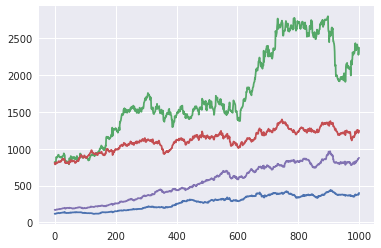

In [234]:
for i in range(4):
    plt.plot(ddd.ix[i,:])

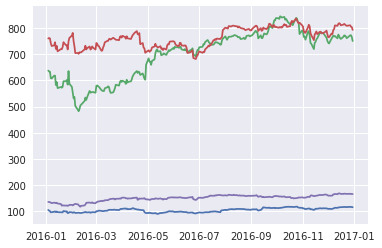

In [235]:
for i in range(4):
    plt.plot(df.ix[i,:])

In [226]:
df

Date,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
minor,,,,,,,,,,,,,,,,,,,,,
AAPL,105.349998,102.709999,100.699997,96.449997,96.959999,98.529999,99.959999,97.389999,99.519997,97.129997,...,115.970001,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000
AMZN,636.989990,633.789978,632.650024,607.940002,607.049988,617.739990,617.890015,581.809998,593.000000,570.179993,...,757.770020,766.000000,771.219971,770.599976,766.340027,760.590027,771.400024,772.130005,765.150024,749.869995
GOOGL,759.440002,761.530029,759.330017,741.000000,730.909973,733.070007,745.340027,719.570007,731.390015,710.489990,...,809.840027,812.500000,815.200012,812.200012,809.679993,807.799988,809.929993,804.570007,802.880005,792.450012
IBM,135.949997,135.850006,135.169998,132.860001,131.630005,133.229996,132.899994,131.169998,132.910004,130.029999,...,166.729996,166.679993,167.600006,167.330002,167.059998,166.710007,167.139999,166.190002,166.600006,165.990005
